In [1]:
import Modules.SQcircuit_extensions as sq_ext
import Modules.figures as figs
import SQcircuit as sq
import numpy as np
import matplotlib.pyplot as plt
import importlib
import qutip as qt
import sympy as sym


%matplotlib ipympl
plt.rcParams['text.usetex'] = False
importlib.reload(sq_ext)
importlib.reload(sq)
importlib.reload(figs)
np.set_printoptions(linewidth=300, formatter={'float': '{:.4f}'.format})

In [462]:
gq_values = np.linspace(0, 10, 10) 
δ_values  = np.linspace(0, 10, 10)
gΦ = 0.5

gcc_by_gq = 0.5
gqq_by_gq = 0.5
gqc_by_gq = -0.5

δ_indices = [0,5,9]
gq_indices = [0,5,9]

In [463]:
k = np.linspace(-np.pi, np.pi, 100)
H_k = np.zeros([len(gq_values), len(δ_values), len(k), 2, 2], dtype = 'complex')
E_k = np.zeros([len(gq_values), len(δ_values), len(k), 2])
E_2k = np.zeros([len(gq_values), len(δ_values), len(k), 2])

σx, σy, σz = sq_ext.pauli_matrices()

for l in range(len(gq_values)):
    for m in range(len(δ_values)):
        for i in range(len(k)):
            # H_k[l, m, i] = np.array([[δ_values[m]/2 + 2*gq_values[l]*gcc_by_gq*np.cos(k[i]), gΦ + 1j*2*gq_values[l]*gqc_by_gq*np.sin(k[i])],
            #         [gΦ - 1j*2*gq_values[l]*gqc_by_gq*np.sin(k[i]), -δ_values[m]/2 - 2*gq_values[l]*gqq_by_gq*np.cos(k[i])]])
            H_k[l, m, i] = (δ_values[m]/2 +   gq_values[l]*(gcc_by_gq+gqq_by_gq)*np.cos(k[i])) * σz + \
                           gΦ * σx + \
                           2 * gq_values[l] * gqc_by_gq * np.sin(k[i]) * σy 
            E_k[l, m, i, :] = np.linalg.eigh(H_k[l, m, i,:])[0]
            # E_2k[l, m, i, 1] = np.sqrt(((δ_values[m]/2 + 2 * gq_values[l]*(gcc_by_gq+gqq_by_gq))*np.cos(k[i]))**2+(gΦ)**2+(2 * gq_values[l] * gqc_by_gq * np.sin(k[i]))**2)
            # E_2k[l, m, i, 0] = -np.sqrt(((δ_values[m]/2 + 2 * gq_values[l]*(gcc_by_gq+gqq_by_gq))*np.cos(k[i]))**2+(gΦ)**2+(2 * gq_values[l] * gqc_by_gq * np.sin(k[i]))**2)

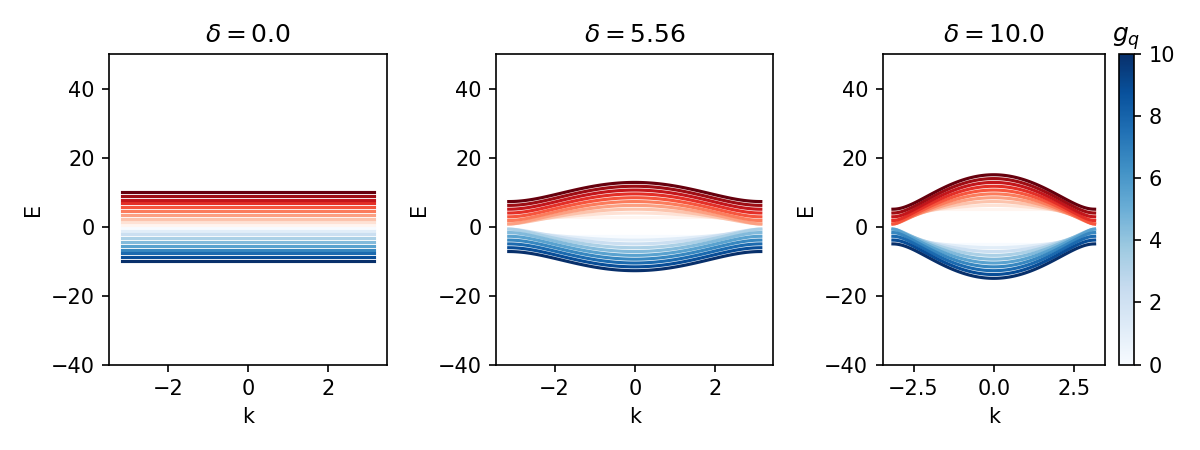

In [464]:
fig, axes = plt.subplots(ncols=3, figsize=[8,3], dpi=150)

colors_0 = figs.generate_colors_from_colormap(len(gq_values), 'Blues')
colors_1 = figs.generate_colors_from_colormap(len(gq_values), 'Reds')

for ax, δ_index in zip(axes,δ_indices):
    
    for l in range(len(gq_values)):
            ax.plot(k, E_k[l, δ_index, :, 0], color=colors_0[l])
            ax.plot(k, E_k[l, δ_index, :, 1], color=colors_1[l])
        
    ax.set_ylabel('E')
    ax.set_xlabel('k')
    ax.set_title(f'$\delta = {np.round(δ_values[δ_index],2)}$')
    ax.set_ylim([-40,50])
    
figs.colorbar_for_lines(fig, axes[-1], gq_values, 'Blues', label = f'$g_q$')

fig.tight_layout()


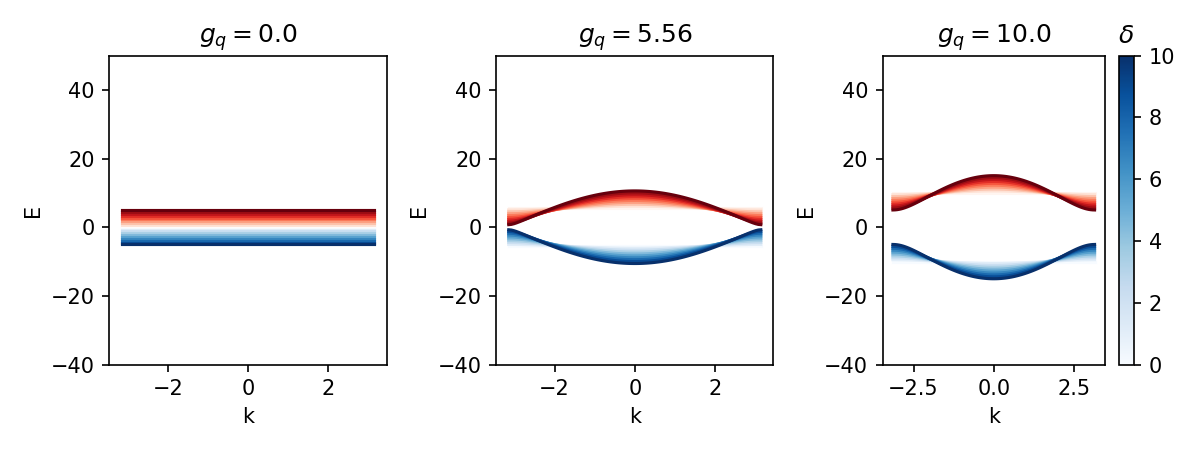

In [465]:
fig, axes = plt.subplots(ncols=3, figsize=[8,3], dpi=150)

colors_0 = figs.generate_colors_from_colormap(len(δ_values), 'Blues')
colors_1 = figs.generate_colors_from_colormap(len(δ_values), 'Reds')

for ax, gq_index in zip(axes,gq_indices):
    
    for m in range(len(δ_values)):
            ax.plot(k, E_k[gq_index, m, :, 0], color=colors_0[m])
            ax.plot(k, E_k[gq_index, m, :, 1], color=colors_1[m])
        
    ax.set_ylabel('E')
    ax.set_xlabel('k')
    ax.set_title(f'$g_q = {np.round(gq_values[gq_index],2)}$')
    ax.set_ylim([-40,50])
    
figs.colorbar_for_lines(fig, axes[-1], δ_values, 'Blues', label = f'$\delta$')

fig.tight_layout()


In [466]:
# Sphere
u = np.linspace(0, 2*np.pi, 100)
v = np.linspace(0, np.pi, 100)
x_sphere = np.outer(np.cos(u), np.sin(v))
y_sphere = np.outer(np.sin(u), np.sin(v))
z_sphere = np.outer(np.ones(np.size(u)), np.cos(v))

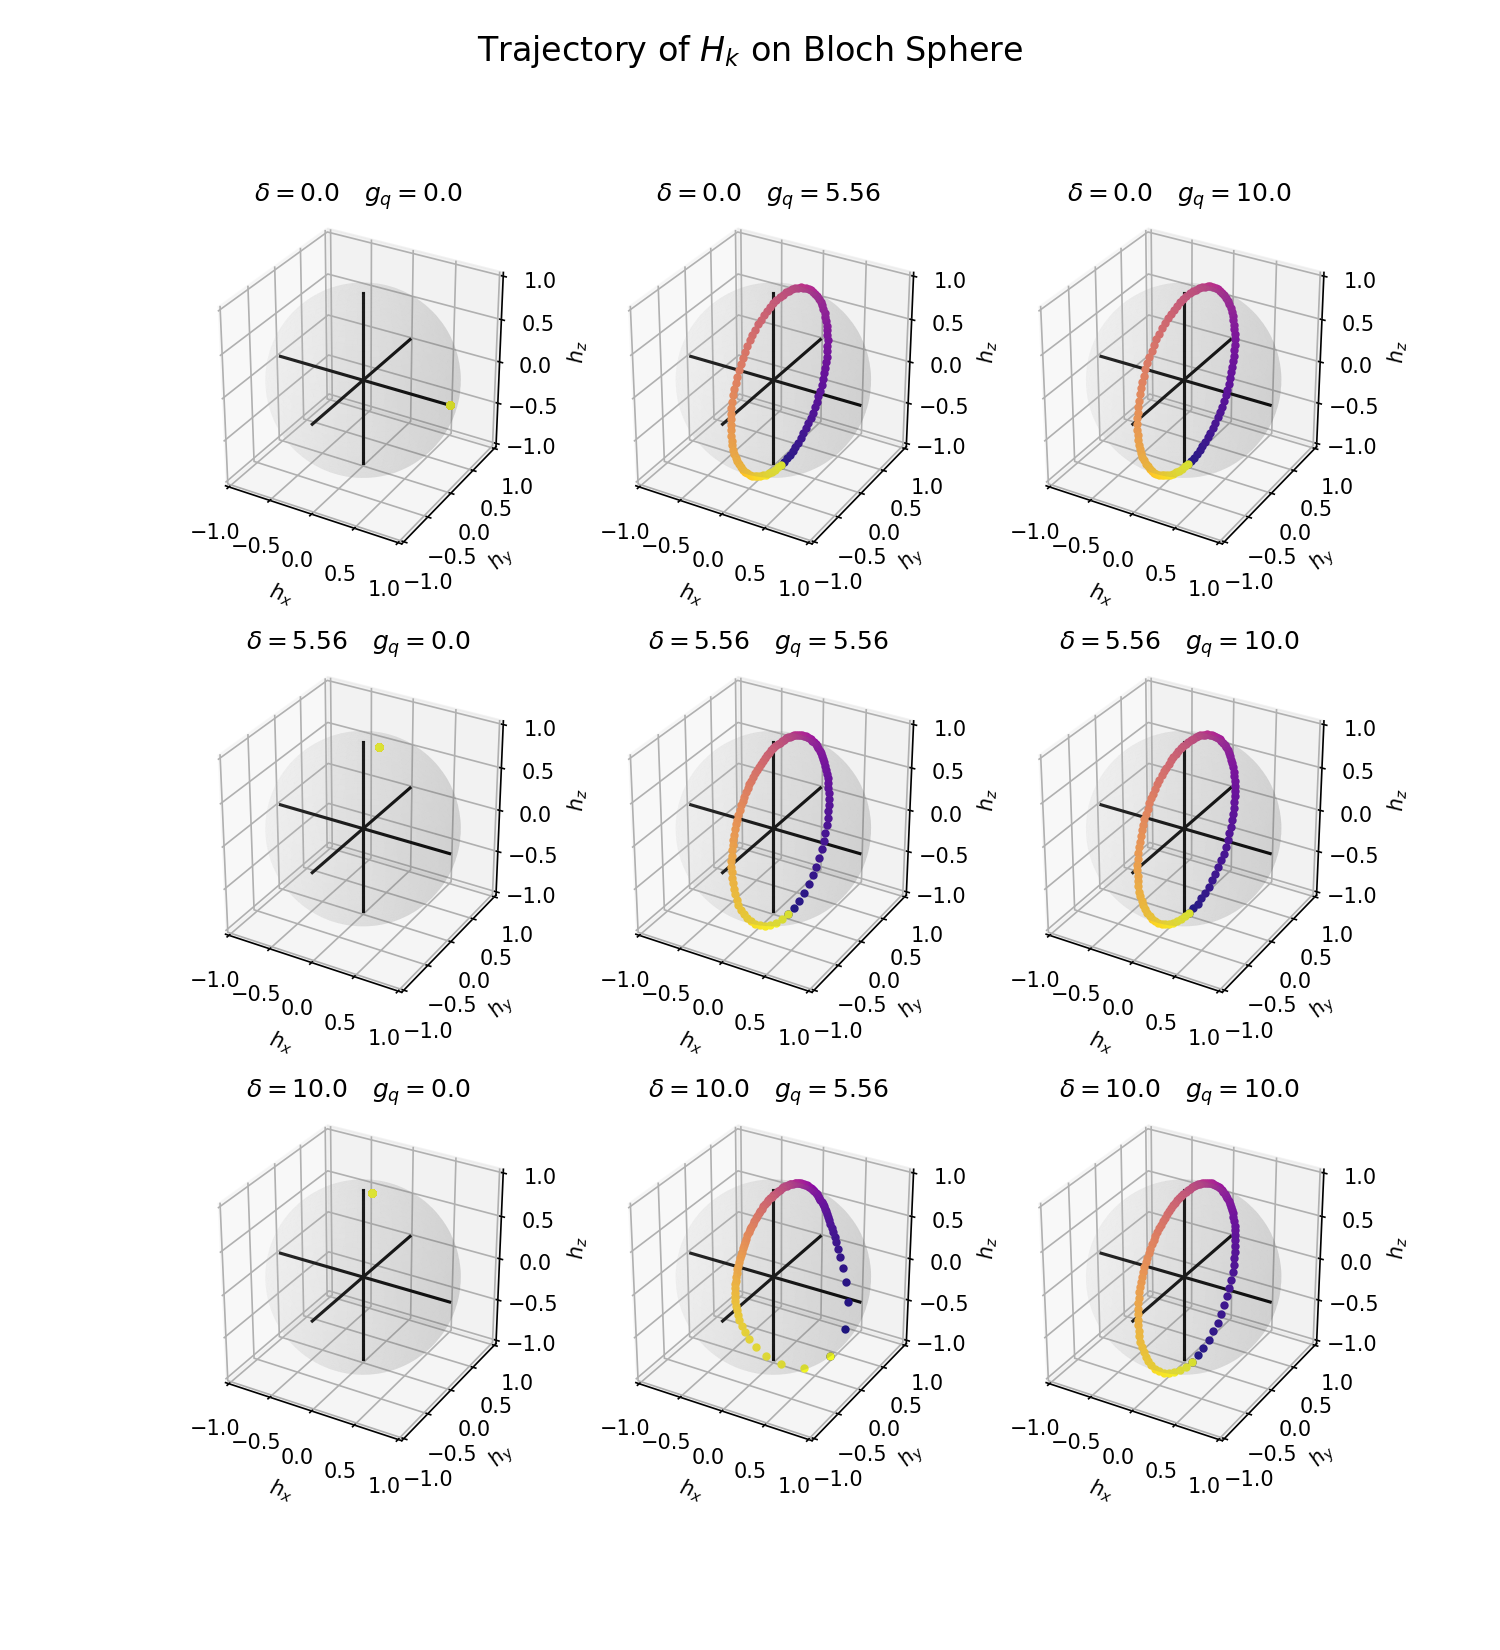

In [467]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=[10,11], dpi=150, subplot_kw={"projection": "3d"})
colors = figs.generate_colors_from_colormap(len(k), 'plasma')

for l, δ_index in enumerate(δ_indices):

    for m, gq_index in enumerate(gq_indices):
        ax = axes[l,m]
        
        ax.plot_surface(x_sphere, y_sphere, z_sphere, color='lightgray', alpha=0.1)
        ax.plot([-1,1], [0,0], [0,0],'k')
        ax.plot([0,0],[-1,1],  [0,0],'k')
        ax.plot( [0,0], [0,0],[-1,1],'k')
        
        
        hx, hy, hz  = [ np.zeros(len(k)) for _ in range(3)]
        
        for i in range(len(k)):
            _, hx[i], hy[i], hz[i] =  sq_ext.decomposition_in_pauli_2x2(H_k[gq_index, δ_index, i])
            # hx[i] = gΦ
            # hy[i] = 2 * gq_values[m] * gqc_by_gq * np.sin(k[i])
            # hz[i] = (δ_values[l]/2 + 2 * gq_values[m]*(gcc_by_gq+gqq_by_gq))*np.cos(k[i])
        
        norm = np.sqrt(hx**2 + hy**2 + hz**2)
        hx_norm = hx / norm
        hy_norm = hy / norm
        hz_norm = hz / norm
        
                # Plot trajectory 
        for i in range(len(k)):
            ax.plot(hx_norm[i], hy_norm[i], hz_norm[i],'.', color=colors[i])
    
        ax.set_xlabel(r'$h_x$')
        ax.set_ylabel(r'$h_y$')
        ax.set_zlabel(r'$h_z$')
        ax.set_box_aspect([1,1,1])
        ax.set_xlim([-1,1])
        ax.set_ylim([-1,1])
        ax.set_zlim([-1,1])
        
        ax.set_title(f'$\delta = {np.round(δ_values[δ_index],2)} \quad g_q  = {np.round(gq_values[gq_index],2)}$')        

fig.suptitle(r'Trajectory of $H_k$ on Bloch Sphere', fontsize=16)
plt.show()

In [468]:
plt.close('all')

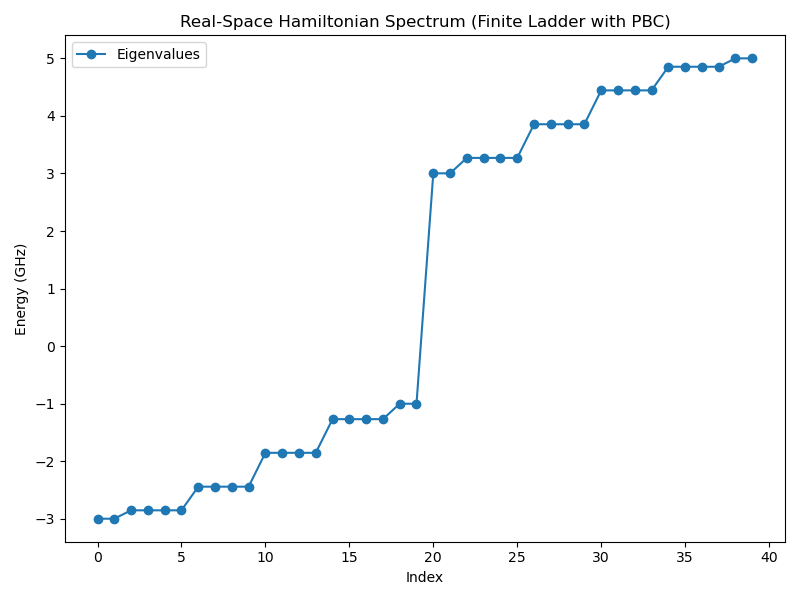

In [496]:
import numpy as np
import matplotlib.pyplot as plt

# System parameters (example values in GHz)
omega_c =  1 # Onsite frequency for mode a (resonator)
omega_q =  1  # Onsite frequency for mode b (qubit)
g_phi   =  0.1 # Intra-cell coupling between a and b
g_cc    =  1 # Hopping between adjacent a modes
g_qq    =  1  # Hopping between adjacent b modes
g_qc    =  2  # Cross-coupling between b_n and a_{n+1} (and vice versa with opposite sign)


# Number of unit cells
N = 20

# Total Hilbert space dimension: 2 modes per cell
dim = 2 * N

# Initialize the Hamiltonian matrix (complex valued)
H_real = np.zeros((dim, dim), dtype=np.complex128)

# Helper function to implement periodic boundary conditions:
def pbc(n, N):
    return n % N

# Loop over unit cells to build H_real
for n in range(N):
    # Basis ordering: index 2*n for mode a, index 2*n+1 for mode b at cell n.
    idx_a = 2 * n      # mode a in cell n
    idx_b = 2 * n + 1  # mode b in cell n

    # Onsite terms
    H_real[idx_a, idx_a] += omega_c
    H_real[idx_b, idx_b] += omega_q

    # Intra-cell (onsite) coupling between a and b (and its Hermitian conjugate)
    H_real[idx_a, idx_b] += g_phi
    H_real[idx_b, idx_a] += g_phi

    # Inter-cell couplings: couple cell n with cell n+1 (with periodic BC)
    # Determine indices for cell n+1 using periodic boundary conditions:
    n_next = pbc(n + 1, N)
    idx_a_next = 2 * n_next      # a in cell n+1
    idx_b_next = 2 * n_next      + 1  # b in cell n+1

    # Coupling between adjacent a modes (resonators): g_cc (real, + sign)
    H_real[idx_a, idx_a_next] += g_cc
    H_real[idx_a_next, idx_a] += g_cc

    # Coupling between adjacent b modes (qubits): g_qq (real, - sign)
    H_real[idx_b, idx_b_next] += -g_qq
    H_real[idx_b_next, idx_b] += -g_qq

    # Cross-coupling: from b in cell n to a in cell n+1: -g_qc
    H_real[idx_b, idx_a_next] += -g_qc
    H_real[idx_a_next, idx_b] += -g_qc

    # Cross-coupling: from a in cell n to b in cell n+1: +g_qc
    H_real[idx_a, idx_b_next] += g_qc
    H_real[idx_b_next, idx_a] += g_qc


# Diagonalize the Hamiltonian
eigvals, eigvecs = np.linalg.eig(H_real)
eigvals = np.sort(np.real(eigvals))  # sorting eigenvalues

# Plot the eigenvalue spectrum
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(np.arange(dim), eigvals, 'o-', label='Eigenvalues')
ax.set_xlabel('Index')
ax.set_ylabel('Energy (GHz)')
ax.set_title('Real-Space Hamiltonian Spectrum (Finite Ladder with PBC)')
ax.legend()
fig.tight_layout()


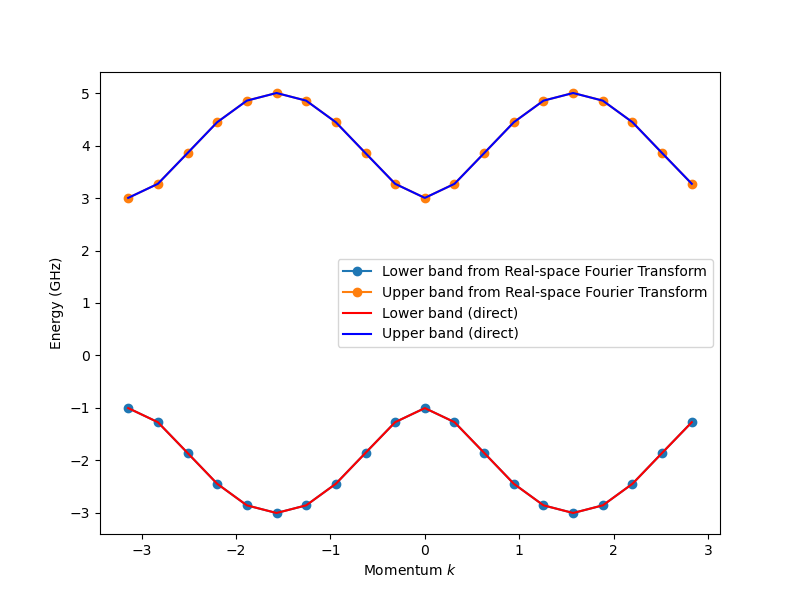

In [497]:
# Create the Fourier transform matrix F for the cell indices (N x N)
F = np.zeros((N, N), dtype=np.complex128)
for n in range(N):
    for m in range(N):
        k = 2 * np.pi * m / N  # allowed discrete momentum
        F[n, m] = np.exp(1j * k * n) / np.sqrt(N)

# Build the full Fourier transform matrix U for the 2N-dimensional space:
# U = F \otimes I_2
I2 = np.eye(2, dtype=np.complex128)
U = np.kron(F, I2)

# Transform the real-space Hamiltonian into momentum space
H_mom = U.conj().T @ H_real @ U

# Now, H_mom should be block-diagonal.
# Extract the 2x2 blocks for each momentum value:
Hk_blocks = np.zeros((N, 2, 2), dtype=np.complex128)
eigvals_mom = np.zeros((N, 2))
for m in range(N):
    # The block corresponding to momentum k = 2pi*m/N is:
    Hk_blocks[m] = H_mom[2*m:2*m+2, 2*m:2*m+2]
    eigvals = np.linalg.eigvals(Hk_blocks[m])
    eigvals_mom[m] = np.sort(np.real(eigvals))

# Construct corresponding k values
k_vals = np.array([2*np.pi*m/N for m in range(N)])-np.pi

# Plot the momentum-space bands from the block diagonalization
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(k_vals, eigvals_mom[:, 0], 'o-', label='Lower band from Real-space Fourier Transform')
ax.plot(k_vals, eigvals_mom[:, 1], 'o-', label='Upper band from Real-space Fourier Transform')
ax.set_xlabel('Momentum $k$')
ax.set_ylabel('Energy (GHz)')

# For comparison, we also construct the momentum-space Hamiltonian directly:
E_band1 = np.zeros(N)
E_band2 = np.zeros(N)
for m, k in enumerate(k_vals):
    M_k = np.array([[omega_c + 2*g_cc*np.cos(k), g_phi + 1j*2*g_qc*np.sin(k)],
                    [g_phi - 1j*2*g_qc*np.sin(k), omega_q - 2*g_qq*np.cos(k)]])
    
    # M_k = ((omega_c-omega_q)/2 +  (g_cc + g_qq )*np.cos(k))  * σz + \
    #       gΦ * σx + \
    #       2 * g_qc * np.sin(k) * σy
    eigvals = np.linalg.eigvals(M_k)
    eigvals = np.sort(np.real(eigvals))
    E_band1[m] = eigvals[0]
    E_band2[m] = eigvals[1]

ax.plot(k_vals, E_band1, 'r-', label='Lower band (direct)')
ax.plot(k_vals, E_band2, 'b-', label='Upper band (direct)')

ax.legend()

Chosen eigenvalue ~ -3.001249804748513


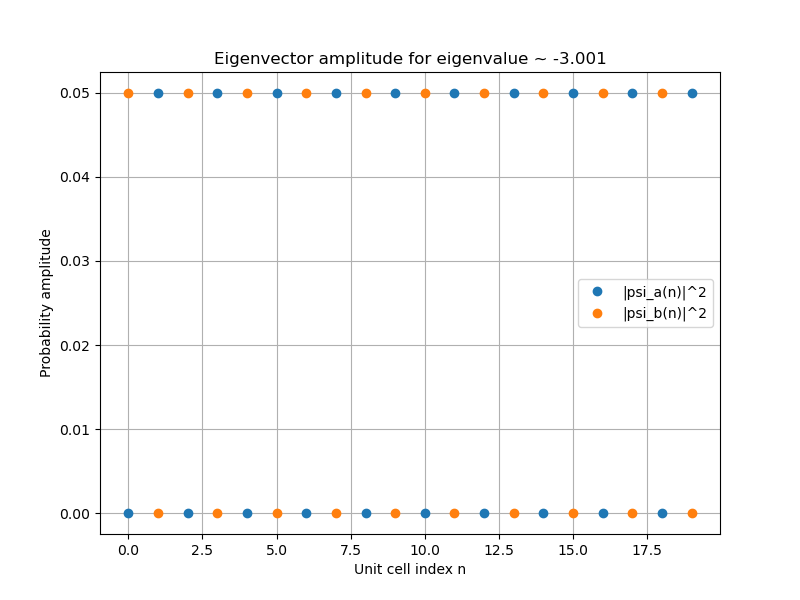

In [500]:
# Assume you already have H_real and N, dim, etc., from your existing code.

# 1) Diagonalize H_real
eigvals_real, eigvecs_real = np.linalg.eig(H_real)
eigvals_real = np.real(eigvals_real)
idx_sort = np.argsort(eigvals_real)
eigvals_sorted = eigvals_real[idx_sort]
eigvecs_sorted = eigvecs_real[:, idx_sort]  # columns are eigenvectors

# 2) Pick an eigenstate index, for example the middle of the spectrum if there's a gap
mid_index = dim // 2  # or any other index of interest
# mid_index = 0  # or any other index of interest
eigenvalue_of_interest = eigvals_sorted[mid_index]
eigenvector_of_interest = eigvecs_sorted[:, mid_index]  # column

print(f"Chosen eigenvalue ~ {eigenvalue_of_interest}")

# 3) Separate amplitude for each site, recall basis: 2n -> a_n, 2n+1 -> b_n
amplitudes_a = []
amplitudes_b = []
for n in range(N):
    amp_a_n = eigenvector_of_interest[2*n]
    amp_b_n = eigenvector_of_interest[2*n+1]
    amplitudes_a.append(np.abs(amp_a_n)**2)
    amplitudes_b.append(np.abs(amp_b_n)**2)

# 4) Plot to see if it is localized near boundaries
sites = np.arange(N)  # site index
plt.figure(figsize=(8,6))
plt.plot(sites, amplitudes_a, 'o', label='|psi_a(n)|^2')
plt.plot(sites, amplitudes_b, 'o', label='|psi_b(n)|^2')
plt.xlabel('Unit cell index n')
plt.ylabel('Probability amplitude')
plt.title(f'Eigenvector amplitude for eigenvalue ~ {eigenvalue_of_interest:.3f}')
plt.legend()
plt.grid(True)
plt.show()
